In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf,poisson_logpmf

In [2]:
data = pd.read_csv('../data_sets/AZ_FLU_HOSPITALIZATIONS.csv',index_col = False).to_numpy().T[1]
data = np.expand_dims(data,0)

In [3]:
def SIRH_model(particles,observations,t,dt,model_params,rng):
    hosp,D,mu,sig = model_params

    lam = 1/7
    L = 1/100
    gamma = 1/1_000

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_S = rng.poisson((L * particles[index,3,t]) * dt)
        new_I = rng.poisson((particles[index,4,t] * (particles[index,0,t] * particles[index,1,t])/np.sum(particles[index,:,t])) * dt)
        new_IH = rng.poisson((D * gamma * particles[index,1,t]) * dt)
        new_HR = rng.poisson((hosp * particles[index,2,t]) * dt)
        new_IR = rng.poisson((D *(1 - gamma) * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] + new_S - new_I)
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - (new_IH + new_IR))
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_IH - new_HR)
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_HR + new_IR - new_S)

        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SIRH_Obs(data_point, particle_observations, model_params):
    weights = poisson_logpmf(k = data_point, mu = particle_observations[:,0] + 0.005)
    return weights


In [4]:
def SIRH_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 7_329_000
    I_init = rng.integers(10_000,200_000,size = (num_particles))
    R_init = rng.integers(100_000,1_000_000,size = (num_particles))
    particles_0[:,0] -= (I_init + R_init)
    particles_0[:,1] = I_init
    particles_0[:,2] = 8
    particles_0[:,3] = R_init
    particles_0[:,4] = rng.uniform(0.2,0.8, size = (num_particles,))
    

    return particles_0



In [5]:
pmcmc_rng = np.random.default_rng(0)

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

def sirh_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 0.,max_val= 1.) + \
    uniform_numba_logpdf(theta[1],min_val = 1/20.,max_val = 1/2.) + \
    uniform_numba_logpdf(theta[2],min_val = -2.,max_val=-1.) + \
    uniform_numba_logpdf(theta[3],min_val = 0.,max_val=5.)


'''estimated params gamma,R,mean_ou,sig'''

pmcmc_params = {'iterations':100_000,
                'init_params':np.array([0.1,0.1,-1.,0.01]),
                'prior':sirh_prior,
                'init_cov':  np.diag([0.01,0.01,0.01,0.01]),
                'burn_in':1_000}

pf_params = {'num_particles':1_000, 
                      'dt':1.,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init
                      }

pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = pmcmc_rng,
                  req_jit=True
                  )


/Users/averydrennan/PMCMC-1/examples/../pmcmc.py:117: RuntimeWarning: invalid value encountered in scalar subtract
  ratio = (LL_new - LL[iter-1])


iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -925.3713467326712| Proposal [ 0.08470438  0.26260915 -1.07915817  0.0518297 ]
iteration: 20| Acceptance rate: 0.1| Log-Likelihood: -889.4137483920666| Proposal [ 0.11774897  0.20115622 -1.20184438  0.12819247]
iteration: 30| Acceptance rate: 0.1| Log-Likelihood: -882.5459734756284| Proposal [ 0.09731676  0.26885266 -1.13936047  0.23739928]
iteration: 40| Acceptance rate: 0.1| Log-Likelihood: -881.8967324865287| Proposal [ 0.11249161  0.20717657 -1.140123    0.27143952]
iteration: 50| Acceptance rate: 0.08| Log-Likelihood: -881.8967324865287| Proposal [ 0.11249161  0.20717657 -1.140123    0.27143952]
iteration: 60| Acceptance rate: 0.06666666666666667| Log-Likelihood: -881.8967324865287| Proposal [ 0.11249161  0.20717657 -1.140123    0.27143952]
iteration: 70| Acceptance rate: 0.05714285714285714| Log-Likelihood: -881.8967324865287| Proposal [ 0.11249161  0.20717657 -1.140123    0.27143952]
iteration: 80| Acceptance rate: 0.0625| Log

-871.9727425668748
The Maximum Likelihood Estimate is [ 0.18056158  0.13262016 -1.58098974  0.18108321] w/ LL of -871.9727425668748


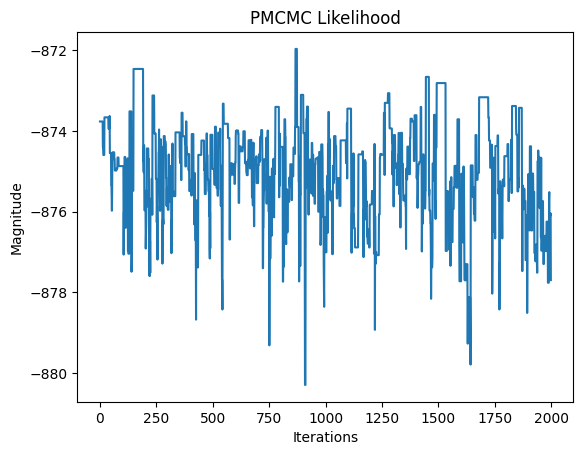

In [ ]:
burn_in = 8000

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'][burn_in:])

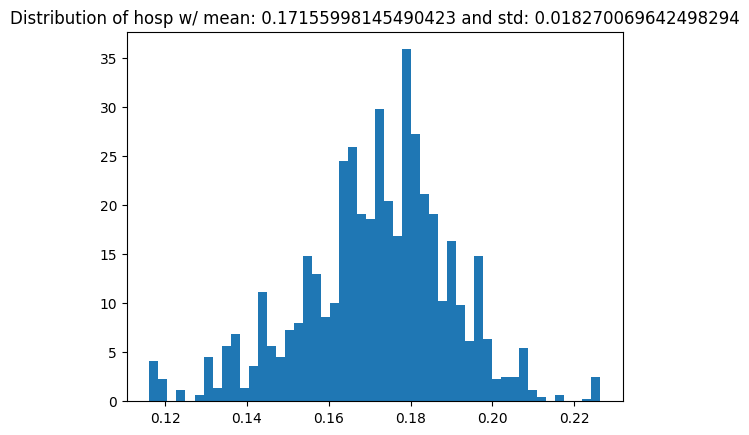

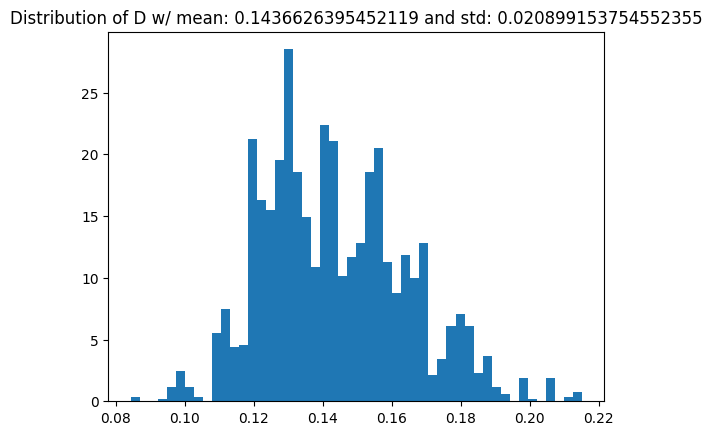

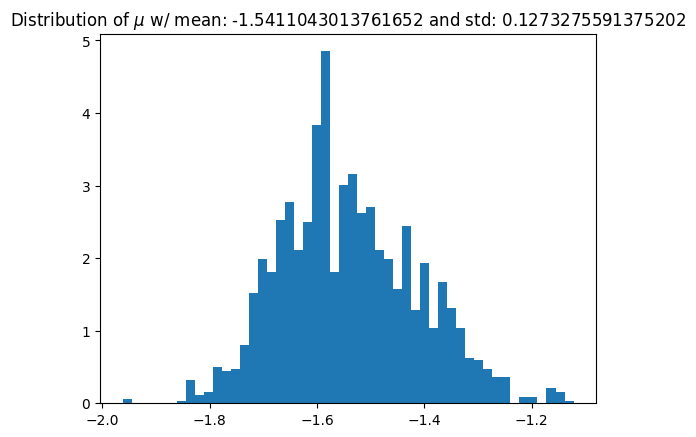

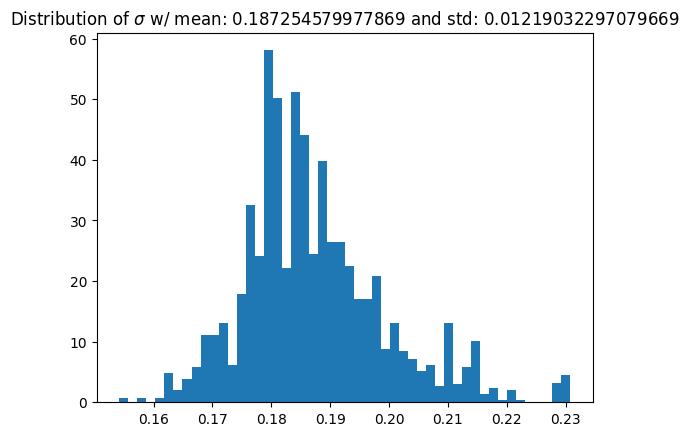

In [ ]:
plt.title(f"Distribution of hosp w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of D w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\mu$ w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean((pmcmc_output['accepted_params'][3,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][3,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][3,burn_in:]),density=True,bins = 50)
plt.show()

In [ ]:
par = np.mean((pmcmc_output['accepted_params'][:,burn_in:]),axis = 1)
rng = np.random.default_rng(10)

T = data.shape[1]
dt = 0.1
t_vec = np.arange(0,T,dt)

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

15.773286807999284


 Log Likelihood : -873.843016649885
Root Mean Squared Error for the Data 166.70973848131354


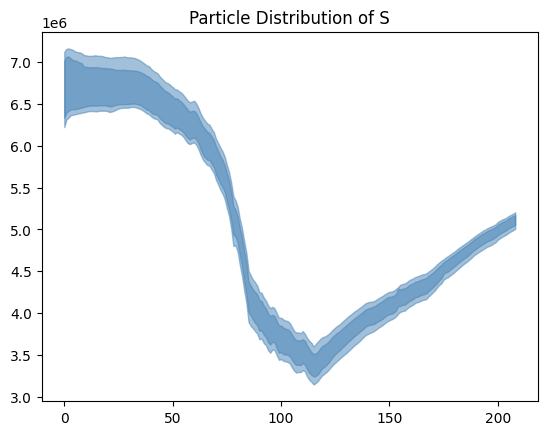

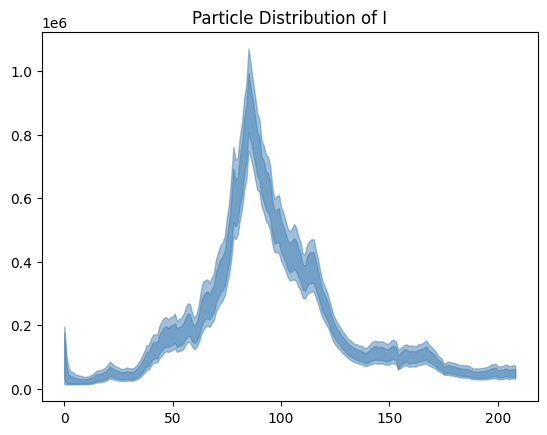

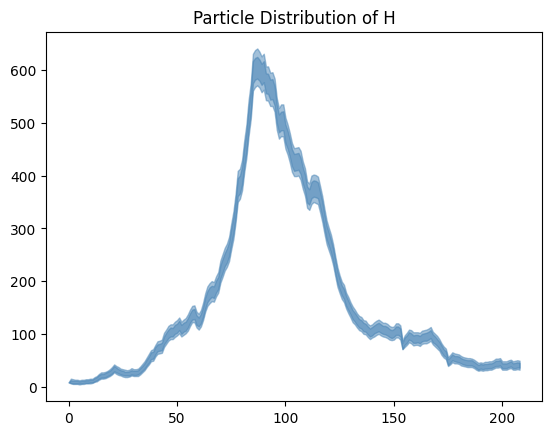

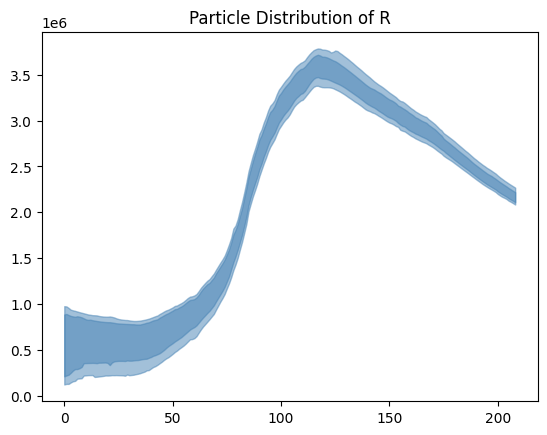

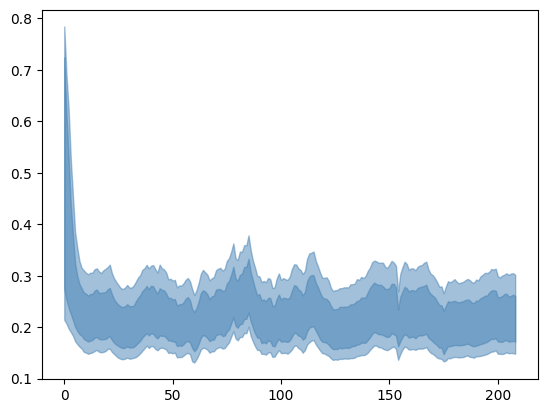

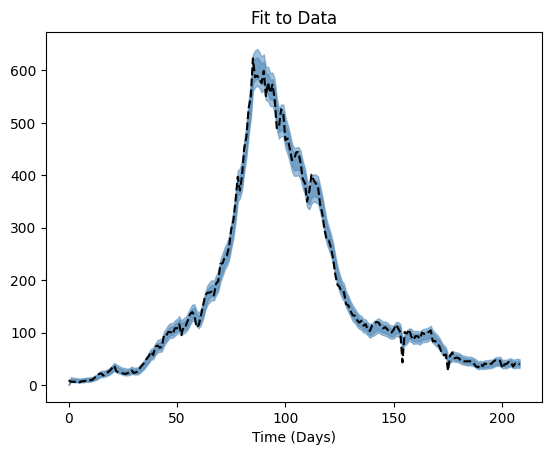

In [ ]:
'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

dt = pf_params['dt']
Labels = ['S','I','H','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.show()

plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [ ]:
np.savez('../pmcmc_output/real_data_pmcmc_output.npz',
accepted_params = pmcmc_output['accepted_params'],
log_likelihood=pmcmc_output['Log Likelihood'],
MLE_particle_dist = pmcmc_output['MLE_particle_dist'],
MLE_particle_observations = pmcmc_output['MLE_particle_observations'])